<a href="https://colab.research.google.com/github/JayX1/Spam-detection/blob/main/spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
ceas_dataset=pd.read_csv('CEAS_08.csv')
enron_dataset=pd.read_csv('enron_data_fraud_labeled.csv')

/tmp/ipython-input-383276074.py:2: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  enron_dataset=pd.read_csv('enron_data_fraud_labeled.csv')


In [35]:
ceas_dataset.info()
ceas_dataset.isna().sum()
ceas_dataset.head()
ceas_dataset= ceas_dataset.drop(columns=['date','receiver','urls'],axis=1)




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


In [36]:

enron_dataset.info()
enron_dataset.isna().sum().isna().sum()
enron_dataset= enron_dataset[['From','Subject','Body','Label']]
enron_dataset=enron_dataset.rename(columns={'From':'sender','Subject':'subject','Body':'body','Label':'label'})
enron_dataset.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447417 entries, 0 to 447416
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Folder-User                447417 non-null  object 
 1   Folder-Name                447417 non-null  object 
 2   Message-ID                 447417 non-null  object 
 3   Date                       447417 non-null  object 
 4   From                       447417 non-null  object 
 5   To                         447417 non-null  object 
 6   Subject                    429397 non-null  object 
 7   Mime-Version               447417 non-null  object 
 8   Content-Type               447417 non-null  object 
 9   Content-Transfer-Encoding  447417 non-null  object 
 10  X-From                     447417 non-null  object 
 11  X-To                       439238 non-null  object 
 12  X-cc                       109637 non-null  object 
 13  X-bcc                      17

,sender,subject,body,label
0,msagel@home.com,Status,Status John: I'm not really sure what happened...,0
1,slafontaine@globalp.com,re:summer inverses,re:summer inverses i suck-hope youve made more...,0
2,iceoperations@intcx.com,The WTI Bullet swap contracts,"The WTI Bullet swap contracts Hi, Following th...",0
3,klarnold@flash.net,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,0
4,soblander@carrfut.com,daily charts and matrices as hot links 5/15,daily charts and matrices as hot links 5/15 Th...,0


In [37]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download punkt_tab
stop_words = set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = nltk.word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    return text

def add_url_counts(df: pd.DataFrame, body_series: pd.Series) -> pd.DataFrame:
    url_pattern = r"https?://[^\s]+"
    df["url_number"] = body_series.fillna("").str.count(url_pattern)
    return df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [38]:
df= pd.concat([ceas_dataset,enron_dataset],axis=0,ignore_index=True)

In [39]:
df = add_url_counts(df,df["body"])

In [40]:
df['body']=df['body'].apply(clean)
df['subject']=df['subject'].apply(clean)
df['sender'] = df['sender'].str.split('@').str[-1]
df


,sender,subject,body,label,url_number
0,iworld.de>,"[never, agree, loser]","[buck, troubles, caused, small, dimension, soo...",1,1
1,icable.ph>,"[befriend, jenna, jameson]","[upgrade, sex, pleasures, techniques]",1,1
2,universalnet.psi.br>,"[cnncom, daily, top]","[daily, top, cnncom, top, videos, stories, aug...",1,24
3,pobox.com>,"[svn, commit, r, spamassassintrunk, libmailspa...","[would, anyone, object, removing, list, tld, b...",0,467
4,loanofficertool.com>,[specialpricespharmmoreinfo],[welcomefastshippingcustomersupport],1,1
...,...,...,...,...,...
486566,enron.com,"[review, board, books, wrebecca, cbillbdavegmi...","[review, board, books, wrebecca, cbillbdavegmi...",0,0
486567,enron.com,"[audit, committee, materials, meeting]","[audit, committee, materials, meeting, two, me...",0,0
486568,enron.com,"[credit, story]","[credit, story, rickbilldavid, generally, mana...",0,0
486569,enron.com,"[commodity, group, limit, issue]","[commodity, group, limit, issue, addition, con...",0,0


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     92481
           1       0.67      0.98      0.80      4834

    accuracy                           0.98     97315
   macro avg       0.84      0.98      0.89     97315
weighted avg       0.98      0.98      0.98     97315

[[90174  2307]
 [  115  4719]]


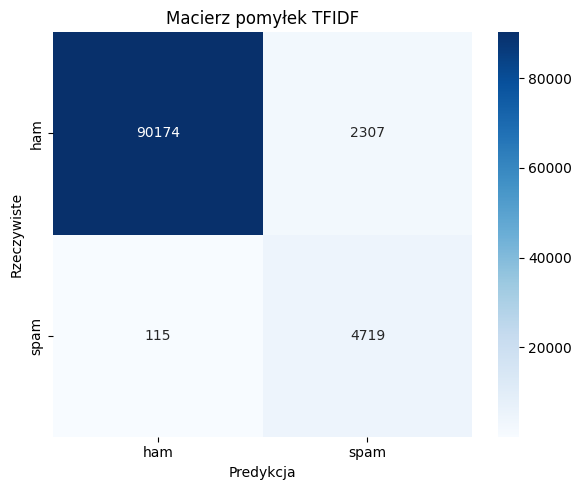

In [41]:
# Model LogisticRegression

def to_text(x):
    if isinstance(x, list):
        return " ".join(map(str, x))
    if pd.isna(x):
        return ""
    return str(x)

df["subject"] = df["subject"].apply(to_text)
df["body"]    = df["body"].apply(to_text)

# Wektoryzacja
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_text = vectorizer.fit_transform(df["subject"] + " " + df["body"])
url_num = df[["url_number"]].fillna(0).astype(float).values
X_num = sp.csr_matrix(url_num)

X = sp.hstack([X_text, X_num], format="csr")
y = df["label"].astype(int)

mask = y.notna()
X = X[mask.values]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)

# Ewaluacja
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywiste")
plt.title("Macierz pomyłek LogisticRegression próg=0.5")
plt.tight_layout()
plt.show()



In [ ]:
# Model LogisticRegression

df["subject"] = df["subject"].apply(to_text)
df["body"]    = df["body"].apply(to_text)

# Wektoryzacja
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_text = vectorizer.fit_transform(df["subject"] + " " + df["body"])
url_num = df[["url_number"]].fillna(0).astype(float).values
X_num = sp.csr_matrix(url_num)

X = sp.hstack([X_text, X_num], format="csr")
y = df["label"].astype(int)

mask = y.notna()
X = X[mask.values]
y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)

# Predykcje z prawdopodobieństwem
y_prob = model.predict_proba(X_test)[:, 1]

# Zmiana progu klasyfikacji
threshold = 0.7
y_pred_custom = (y_prob > threshold).astype(int)

# Ewaluacja
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="seagreen",
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])

plt.xlabel("Predykcja")
plt.ylabel("Rzeczywiste")
plt.title("Macierz pomyłek LogisticRegression próg=0.7")
plt.tight_layout()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3933215099.py", line 15, in <cell line: 0>
    X_text = vectorizer.fit_transform(df["subject"] + " " + df["body"])
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
          

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-3933215099.py", line 15, in <cell line: 0>
    X_text = vectorizer.fit_transform(df["subject"] + " " + df["body"])
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 2104, in fit_transform
    X = super().fit_transform(raw_documents)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py", line 1376, in fit_transform
    vocabulary, X = self._count_vocab(raw_documents, self.fixed_vocabulary_)
          

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      0.98      0.99     92481
           1       0.69      0.97      0.81      4834

    accuracy                           0.98     97315
   macro avg       0.84      0.98      0.90     97315
weighted avg       0.98      0.98      0.98     97315

[[90355  2126]
 [  129  4705]]


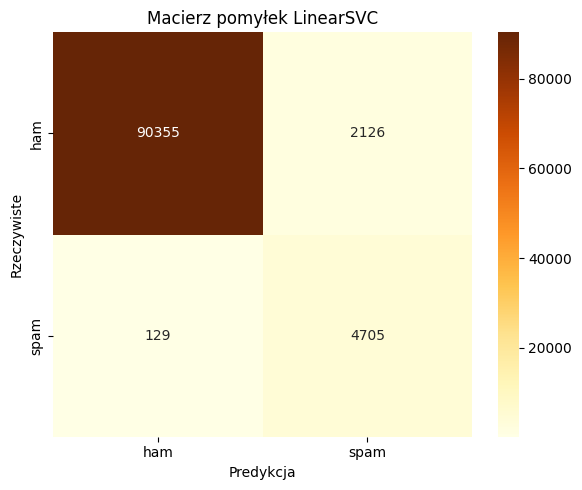

In [42]:
# Model LinearSVC
from sklearn.svm import LinearSVC
def to_text(x):
    if isinstance(x, list):
        return " ".join(map(str, x))
    if pd.isna(x):
        return ""
    return str(x)

df["subject"] = df["subject"].apply(to_text)
df["body"]    = df["body"].apply(to_text)

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_text = vectorizer.fit_transform(df["subject"] + " " + df["body"])

url_num = df[["url_number"]].fillna(0).astype(float).values
X_num = sp.csr_matrix(url_num)

X = sp.hstack([X_text, X_num], format="csr")
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


model = LinearSVC(class_weight="balanced")
model.fit(X_train, y_train)

# Ewaluacja
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrBr",
            xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predykcja")
plt.ylabel("Rzeczywiste")
plt.title("Macierz pomyłek LinearSVC")
plt.tight_layout()
plt.show()